In [69]:
import sys, os, time
import numpy as np
import rbf
import rbf.halton
import ghalton
import matplotlib
import matplotlib.pyplot as plt

In [70]:
%matplotlib notebook

In [71]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 6}

matplotlib.rc('font', **font)

In [3]:
def generate_ghalton_sequence(npoints, seed, dims):
    sequencer = ghalton.GeneralizedHalton(dims, seed)
    return np.asarray(sequencer.get(npoints), dtype='float32')

def generate_rbf_halton_sequence(npoints, seed, dims):
    sequencer = rbf.halton.Halton(D = dims, prime_index = seed)
    return np.asarray(sequencer(npoints), dtype='float32')

def generate_numpy_uniform_sequence(npoints, seed, dims):
    random = np.random.RandomState(seed)
    return random.uniform(low=0., high=1, size=(npoints, dims))

def nearest_neighbor_analysis(npoints, seed, dims, algorithm='uniform'):
    points = None
    if algorithm == 'rbf':
        points = generate_rbf_halton_sequence(npoints, seed, dims)
    elif algorithm == 'ghalton':
        points = generate_ghalton_sequence(npoints, seed, dims)
    elif algorithm == 'uniform':
        points = generate_numpy_uniform_sequence(npoints, seed, dims)
    
    points = np.asarray([points[:,dims-2], points[:,dims-1]]).T
    tree = cKDTree(points)
    
    distances = []
    for n in xrange(points.shape[0]):
        d, _ = tree.query(points[n,:],2)
        distances.append(d[-1])
    return points, np.asarray(distances, dtype='float32')

def correlation_analysis(npoints, seeds, dims, algorithm='uniform'):
    dims = np.arange(dims) + 1
    max_corr_lst = []
    for dim in dims:
        points_lst = []
        for seed in seeds:
            if algorithm == 'rbf':
                points_lst.append(generate_rbf_halton_sequence(npoints, seed, dims))
            elif algorithm == 'ghalton':
                points_lst.append(generate_ghalton_sequence(npoints, seed, dims))
            elif algorithm == 'uniform':
                points_lst.append(generate_numpy_uniform_sequence(npoints, seed, dims))
        points = np.asarray(points_lst)
        ccoef  = np.corrcoef(points[:,:,dim-1])
        ccoef_no_diagonal = np.abs(ccoef[~np.eye(ccoef.shape[0], dtype=bool)].reshape(ccoef.shape[0], -1))
        max_corr_lst.append(np.max(ccoef_no_diagonal))
    return max_corr_lst
                
    

In [4]:
def scatter_plot(x, x_labels, title, legendOn=True):
    plt.figure()
    for i in xrange(len(x)):
        plt.scatter(x[i][:,0], x[i][:,1], label=x_labels[i])
    if legendOn:
        plt.legend()
    plt.title(title)
 
def distances_plot(x, x_labels, title, legendOn=True):
    fig, axes = plt.subplots(2,1)
    for i in xrange(len(x)):
        if i == 0:
            hist, edges = np.histogram(x[i], bins=20)
        else:
            hist, _ = np.histogram(x[i], bins=edges)
        axes[0].plot(x[i], label=x_labels[i])
        axes[1].plot(edges[1:], hist, label=x_labels[i])
    if legendOn:
        axes[0].legend()
        axes[1].legend()
    axes[0].set_title(title)
    
def vanilla_plot(x, y, labels, title, logY=False):
    x = np.asarray(x)
    y = np.asarray(y)

    plt.figure()
    for i in xrange(y.shape[1]):
        plt.plot(x, y[:,i], label=labels[i])
    plt.legend()
    plt.title(title)
    
    if logY:
        plt.yscale('log')
    


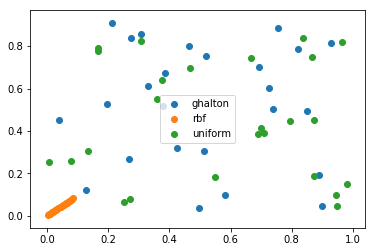

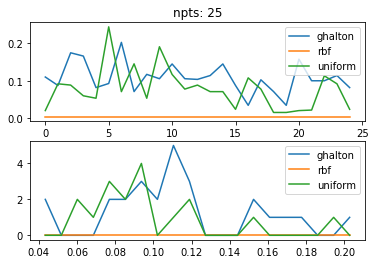

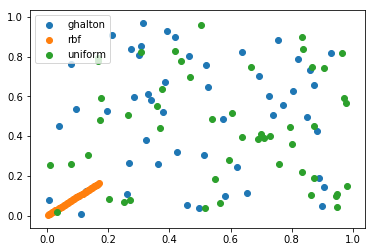

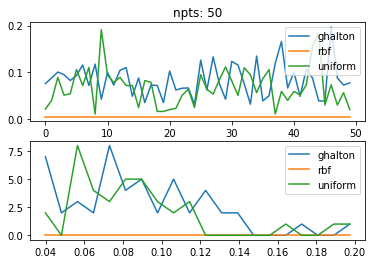

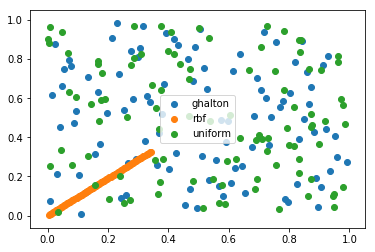

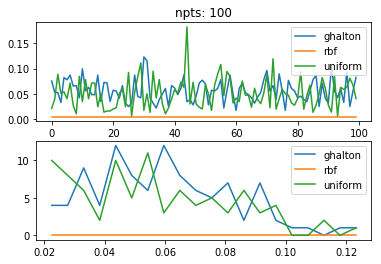

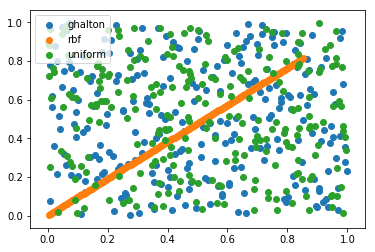

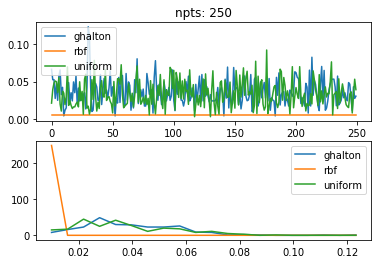

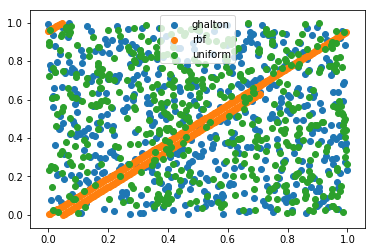

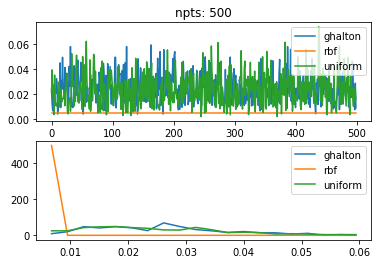

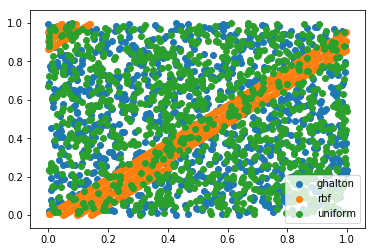

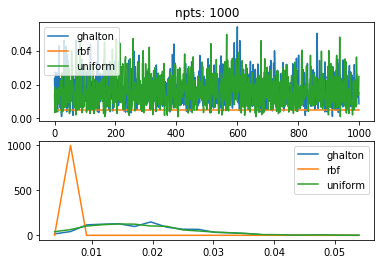

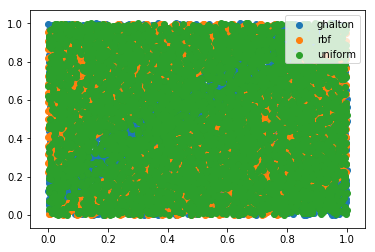

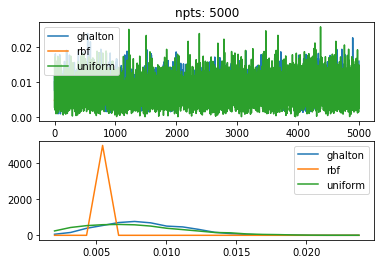

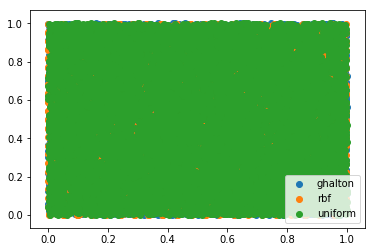

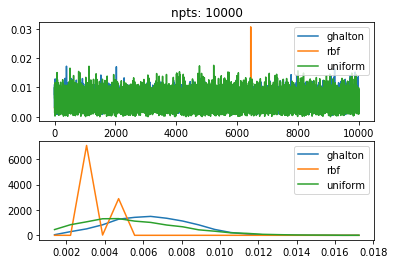

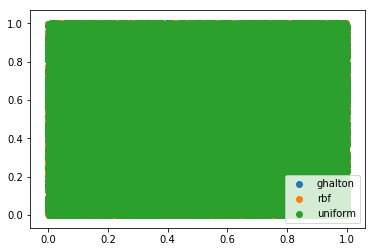

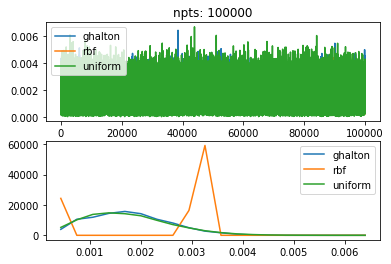

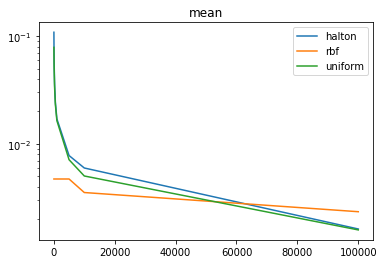

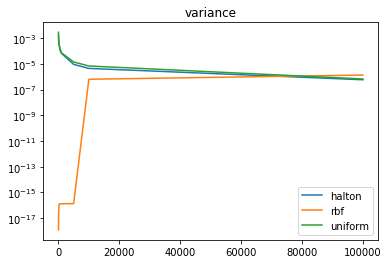

In [17]:
seed = 31
dims = 32

npts_lst = [25, 50, 100, 250, 500, 1000, 5000, 10000, 100000]
mean_stats  = []
var_stats = []
for npts in npts_lst:

    points_rbf_halton, distances_rbf_halton = nearest_neighbor_analysis(npts, seed, dims, algorithm='rbf')
    points_ghalton, distances_ghalton = nearest_neighbor_analysis(npts, seed, dims, algorithm='ghalton')
    points_uniform, distances_uniform = nearest_neighbor_analysis(npts, seed, dims, algorithm='uniform')

    ghalton_mean  = np.mean(distances_ghalton)
    ghalton_var   = np.var(distances_ghalton)
    rbf_mean      = np.mean(distances_rbf_halton)
    rbf_var       = np.var(distances_rbf_halton)
    uniform_mean  = np.mean(distances_uniform)
    uniform_var   = np.var(distances_uniform)
    
    mean_stats.append((ghalton_mean, rbf_mean, uniform_mean))
    var_stats.append((ghalton_var, rbf_var, uniform_var))
           
    plot_title   = 'npts: %i' % (npts)
    
    scatter_plot([points_ghalton, points_rbf_halton, points_uniform], ['ghalton', 'rbf', 'uniform'], '')
    distances_plot([distances_ghalton, distances_rbf_halton, distances_uniform], ['ghalton', 'rbf', 'uniform'], plot_title)

vanilla_plot(npts_lst, mean_stats, ['halton', 'rbf', 'uniform'], 'mean', logY=True)
vanilla_plot(npts_lst, var_stats, ['halton', 'rbf', 'uniform'], 'variance', logY=True)




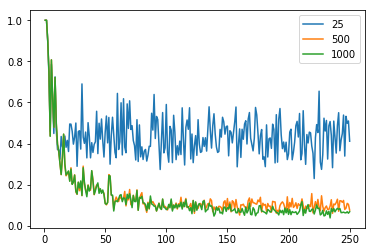

In [74]:
seeds   = [1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
npts_lst = [25, 500, 1000]
dims     = 250

max_lst = []
for npts in npts_lst:
    max_lst.append(correlation_analysis(npts, seeds, dims))
max_lst = np.asarray(max_lst, dtype='float32')

plt.figure()
for i in xrange(max_lst.shape[0]):
    plt.plot(np.arange(dims)+1, max_lst[i,:], label='%i' % (npts_lst[i]))
plt.legend()

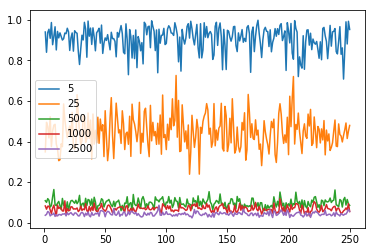

In [5]:
seeds   = [1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
npts_lst = [5, 25, 500, 1000, 2500]
dims     = 250

max_lst = []
for npts in npts_lst:
    max_lst.append(correlation_analysis(npts, seeds, dims, genHalton=False))
max_lst = np.asarray(max_lst, dtype='float32')

plt.figure()
for i in xrange(max_lst.shape[0]):
    plt.plot(np.arange(dims)+1, max_lst[i,:], label='%i' % (npts_lst[i]))
plt.legend()

<IPython.core.display.Javascript object>


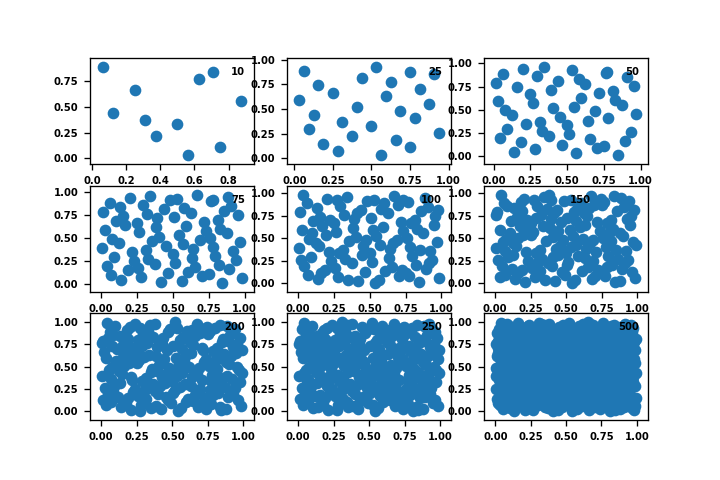

In [89]:
dims = 2
seed = 0 # random
npoints_lst = [10, 25, 50, 75, 100, 150, 200, 250, 500]
plot_dimensions = int(len(npoints_lst) ** 0.5)

fig, axes = plt.subplots(plot_dimensions, plot_dimensions)
for (i,npts) in enumerate(npoints_lst):
    sequencer = rbf.halton.Halton(D = dims, prime_index = seed)
    points = np.asarray(sequencer(npts), dtype='float32')
    axes[i/plot_dimensions,i%plot_dimensions].scatter(points[:,0], points[:,1], label=npoints_lst[i])
    axes[i/plot_dimensions,i%plot_dimensions].legend(frameon=False)


In [72]:
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y

def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r

<IPython.core.display.Javascript object>


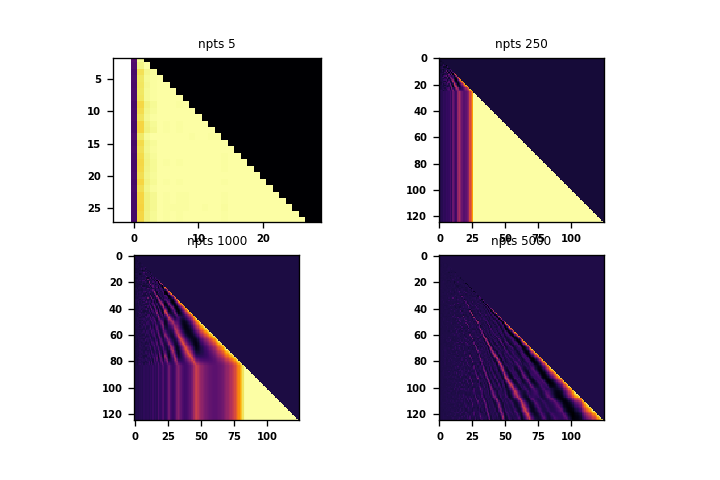

In [74]:
seeds = np.arange(1, 250, 2)
dims  = 2
npts_lst  = [5, 250, 1000, 5000]

fig, axes = plt.subplots(2,2)
for (n,npts) in enumerate(npts_lst):
    pts_lst = []
    for seed in seeds:
        sequencer = rbf.halton.Halton(D = dims, prime_index = seed)
        points = np.asarray(sequencer(npts), dtype='float32')
        #if npts == 5 and n < 5:
        #    print(seed)
        #    print(points)
        pts_lst.append(points)
    points = np.asarray(pts_lst, dtype='float32')

    corr_matrix = np.zeros((len(seeds), len(seeds)))
    for i in xrange(1, points.shape[0]):
        for j in xrange(0, i):
            corr_matrix[i,j] = corr2(points[i].T, points[j].T)
    curr_img = axes[n/2,n%2].imshow(corr_matrix, cmap='inferno', label=npts_lst[n], vmax=1.)
    axes[n/2,n%2].set_title('npts %i' % (npts))



<IPython.core.display.Javascript object>


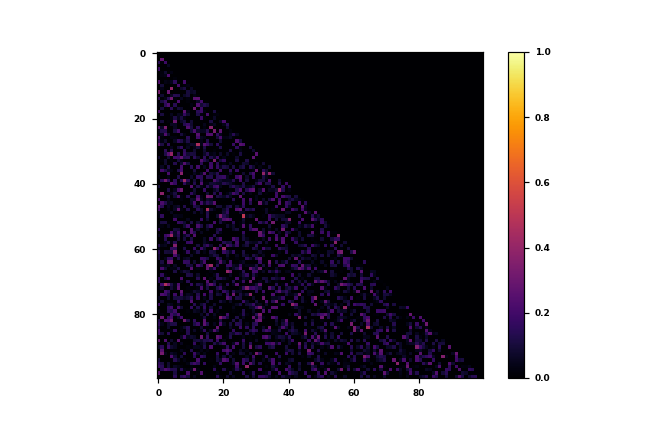

In [108]:
seed = 0
dims = 2
npts = 25
sequencer = rbf.halton.Halton(D = dims, prime_index = seed)
random = np.random.RandomState(seed=0)


iterations = 100
pts_lst = []
for i in xrange(iterations):
    pts = np.asarray(sequencer(npts), dtype='float32')
    random.shuffle(pts)
    pts_lst.append(np.asarray(pts, dtype='float32'))
pts_lst = np.asarray(pts_lst)


corr_matrix_1 = np.zeros((iterations, iterations))
for i in xrange(1, pts_lst.shape[0]):
    for j in xrange(0, i):
        corr_matrix_1[i,j] = corr2(pts_lst[i].T, pts_lst[j].T)
        
        
plt.figure()
plt.imshow(corr_matrix_1, cmap='inferno', vmin=0., vmax=1.)
plt.colorbar()


<IPython.core.display.Javascript object>


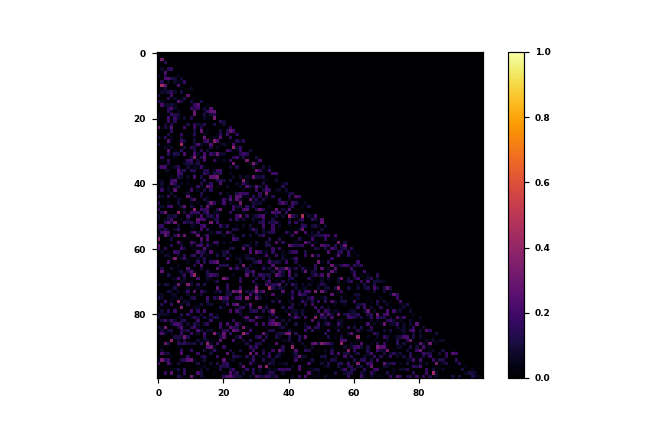

In [111]:
seed = 0
dims = 2
npts = 2500
random = np.random.RandomState(seed=0)
sequencer = rbf.halton.Halton(D = dims, prime_index = seed)
pts = np.asarray(sequencer(npts), dtype='float32')
random.shuffle(pts)

iterations = 100
pts_lst = []
for i in xrange(iterations):
    curr_chunk = pts[25*i:25*i+25]
    pts_lst.append(curr_chunk)
pts_lst = np.asarray(pts_lst, dtype='float32')

corr_matrix_2 = np.zeros((iterations, iterations))
for i in xrange(1, pts_lst.shape[0]):
    for j in xrange(0, i):
        corr_matrix_2[i,j] = corr2(pts_lst[i].T, pts_lst[j].T)
        
        
plt.figure()
plt.imshow(corr_matrix_2, cmap='inferno', vmin=0., vmax=1.)
plt.colorbar()


<IPython.core.display.Javascript object>


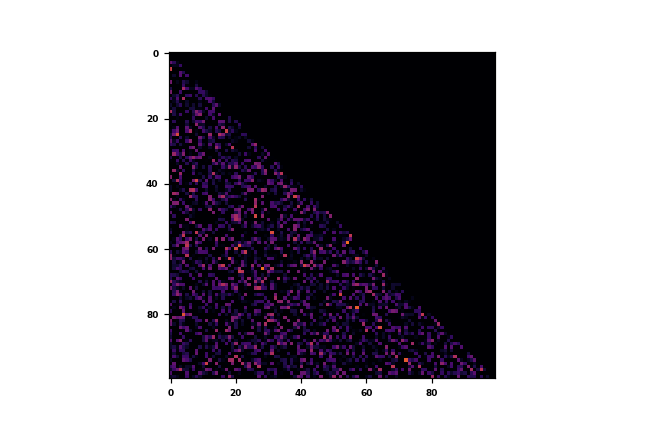

In [113]:
plt.figure()
plt.imshow(corr_matrix_1 - corr_matrix_2, cmap='inferno', vmin=0., vmax=1.)